# Book Recommendation Engine

Data source: http://www2.informatik.uni-freiburg.de/~cziegler/BX/<br><br>
	
Collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community. "BookCrossing is defined as 'the practice of leaving a book in a public place to be picked up and read by others, who then do likewise. The term is derived from bookcrossing.com, a free online book club which was founded to encourage the practice, aiming to "make the whole world a library." - https://en.wikipedia.org/wiki/BookCrossing<br><br>

![Chart Image](https://user-images.githubusercontent.com/30188729/36621380-9a95c4d4-18ac-11e8-84f8-e6b8a3f2ae69.png)

## *Objective*:  Recommend a list of books to an individual based upon their book-rating behavior.  <br>
There are several websites which have algorithms similar to this for the purposes of recommending a book to a reader, such as GoodReads.com.

![Chart Image](https://user-images.githubusercontent.com/30188729/36621147-705a4d62-18ab-11e8-8050-89de819e9b8e.png)

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns; sns.set(color_codes=True)
from sklearn.cluster import KMeans
color = sns.color_palette()
from IPython.core.display import display, HTML
%matplotlib inline

C:\Users\sgus1\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from surprise import SVD as svd
from surprise.model_selection import cross_validate

## Book Crossings Recommendation Engine Practice

Grabbed this data from: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

I did some adjustments and cleaning to the data in BigQuery before loading into pandas.  I also joined the book details, user information and ratings datasets all into one big dataframe in BigQuery. 

In [3]:
url = 'https://raw.githubusercontent.com/sgus1318/recommendation_engine_practice/master/Book_Crossing_Clean_Combined.csv'
df_load = pd.read_csv(url)

C:\Users\sgus1\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [144]:
df=df_load.copy()

In [145]:
df.head()

,User_ID,ISBN,Book_Rating,Location,Age,Title,Author,PubYr,Publisher
0,35459,3499203596,2,augsburg bayern germany,13.000,Die Amis kommen: Ein Hitlerjunge erlebt das Kr...,Gerd Fuchs,1984,Rowohlt
1,56917,1588993736,2,mount vernon iowa usa,2.000,Para Para,Andy Seto,2004,ComicsOne Corporation
2,252510,3853267572,2,münchen bayern germany,1.000,Hauhaltsschnecken leben länger,Christine Nöstlinger,1991,DTV
3,158606,037310667X,2,dunedin florida usa,72.000,Forgotten Passion (Harlequin Presents),Penny Jordan,1984,Harlequin
4,42885,3453006011,2,moormerland niedersachsen germany,59.000,BittersÃ?¼Ã?Â?es siebtes Jahr.,Heinz GÃ?¼nther Konsalik,1976,Heyne


In [146]:
df.describe()

,User_ID,Book_Rating,Age
count,1149766.000,1149766.000,807487.000
mean,140386.239,2.867,36.780
std,80561.908,3.854,12.256
min,2.000,0.000,0.000
25%,70345.000,0.000,28.000
50%,141010.000,0.000,35.000
75%,211028.000,7.000,45.000
max,278854.000,10.000,100.000


In [147]:
df.isnull().sum()

User_ID             0
ISBN                0
Book_Rating         0
Location        56869
Age            342279
Title          952924
Author         952924
PubYr          952924
Publisher      952926
dtype: int64

In [148]:
df_full = df.dropna()

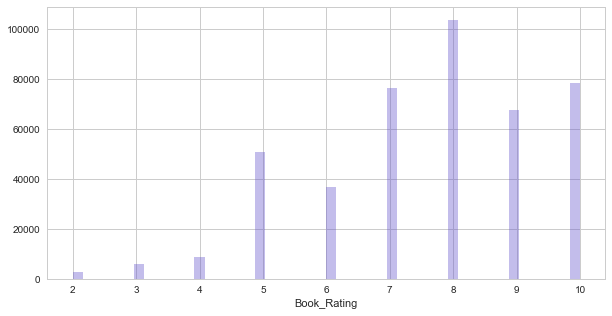

In [171]:
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(df['Book_Rating'],color="slateblue",kde=False)

### Let's drop all rows with a rating of 0.  This means someone didn't enter a score, as the score should be from 1-10.

In [150]:
df = df[df['Book_Rating'] > 1]  

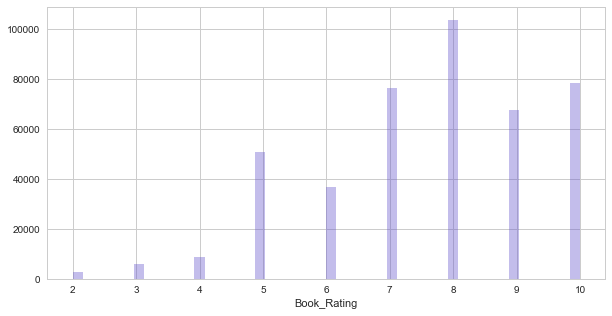

In [172]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(df['Book_Rating'],color="slateblue",kde=False)

In [121]:
len(df)

216733

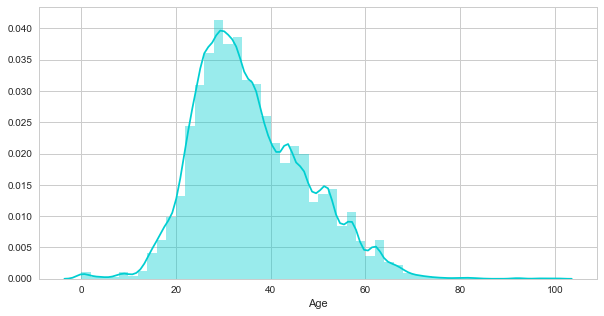

In [153]:
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(df_full['Age'],color="darkturquoise")

In [154]:
df_corr=df_full.drop(['User_ID'], axis=1)

In [155]:
corr = df_corr.corr()

In [156]:
corr

,Book_Rating,Age
Book_Rating,1.000,-0.038
Age,-0.038,1.000


In [157]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate

In [158]:
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['User_ID', 'ISBN', 'Book_Rating']], reader)

algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.1862  3.1868  3.1860  3.1823  3.1815  3.1846  0.0022  
MAE (testset)     2.7658  2.7662  2.7658  2.7597  2.7600  2.7635  0.0030  
Fit time          72.18   73.92   73.25   71.49   44.32   67.03   11.39   
Test time         2.00    1.97    1.74    1.50    1.41    1.72    0.24    


{'fit_time': (72.17749333381653,
  73.91619896888733,
  73.25152516365051,
  71.48662400245667,
  44.31608057022095),
 'test_mae': array([ 2.76577085,  2.76616894,  2.76578549,  2.75974872,  2.75999228]),
 'test_rmse': array([ 3.18621754,  3.18684233,  3.18597257,  3.18225484,  3.1814923 ]),
 'test_time': (1.9958159923553467,
  1.9662435054779053,
  1.741694450378418,
  1.5040063858032227,
  1.4115560054779053)}

In [159]:
from surprise import KNNBaseline
#from surprise import Dataset
from surprise import get_dataset_dir

In [160]:
# First, train the algorithm to compute the similarities between items
data = Dataset.load_from_df(df[['User_ID', 'ISBN', 'Book_Rating']], reader)
trainset = data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
#algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

In [161]:
data217740 = df_full[(df_full['User_ID'] == 217740)]

In [162]:
len(data217740)

241

In [163]:
data217740.head()

,User_ID,ISBN,Book_Rating,Location,Age,Title,Author,PubYr,Publisher
820562,217740,8420638331,0,madrid madrid spain,37.000,Los gozos y las sombras. 3.La pascua triste,Gonzalo Torrente Ballester,1972,Alianza
820575,217740,8433584170,0,madrid madrid spain,37.000,Escenarios fantásticos (Labor bolsillo juvenil...,Joan Manuel Gisbert,1979,Editorial Labor
820611,217740,8423920445,0,madrid madrid spain,37.000,El malvado Carabel (Selecciones Austral ; 44 :...,Wenceslao Fernández-Flórez,1978,Espasa-Calpe
820612,217740,8434811693,0,madrid madrid spain,37.000,Cucho,Jose Luis Olaizola,1984,S &amp; M Books
820613,217740,8484032930,0,madrid madrid spain,37.000,El Conde De Montecristo,Alejandro Dumas,2004,Edimat Libros


In [164]:
data217740.describe()

,User_ID,Book_Rating,Age
count,241.000,241.000,241.000
mean,217740.000,3.083,37.000
std,0.000,3.143,0.000
min,217740.000,0.000,37.000
25%,217740.000,0.000,37.000
50%,217740.000,3.000,37.000
75%,217740.000,6.000,37.000
max,217740.000,10.000,37.000


#### This person's average book rating is 3, with a median of 6.  

In [165]:
user_217740 = df_full.copy()
user_217740 = user_217740.reset_index()

reader = Reader(rating_scale=(1, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['User_ID', 'ISBN', 'Book_Rating']], reader)


trainset = data.build_full_trainset()

svd = SVD()
svd.fit(trainset)

user_217740['Estimate_Score'] = user_217740['ISBN'].apply(lambda x: svd.predict(217740, x).est)

user_217740 = user_217740.drop('ISBN', axis = 1)

In [166]:
user_217740 = user_217740.sort_values('Estimate_Score', ascending=False)
user_217740.head(20)

,index,User_ID,Book_Rating,Location,Age,Title,Author,PubYr,Publisher,Estimate_Score
23278,482043,211426,0,pueblo colorado usa,24.000,Cien Años de Soledad,Gabriel García Márquez,1994.000,Ediciones Catedra S.A.,8.433
89531,840755,217740,10,madrid madrid spain,37.000,Cien Años de Soledad,Gabriel García Márquez,1994,Ediciones Catedra S.A.,8.433
42540,581919,82426,0,carcavelos lisboa portugal,28.000,Cien Años de Soledad,Gabriel García Márquez,1994,Ediciones Catedra S.A.,8.433
32325,529511,74215,0,lyon rhône-alpes france,26.000,Cien Años de Soledad,Gabriel García Márquez,1994,Ediciones Catedra S.A.,8.433
54444,645741,99469,8,madrid madrid spain,30.000,Cien Años de Soledad,Gabriel García Márquez,1994,Ediciones Catedra S.A.,8.433
75871,766512,87776,9,cádiz andalucía spain,34.000,Cien Años de Soledad,Gabriel García Márquez,1994,Ediciones Catedra S.A.,8.433
9075,404606,152483,10,braga braga portugal,18.000,Cien Años de Soledad,Gabriel García Márquez,1994,Ediciones Catedra S.A.,8.433
80710,788529,87326,10,la garriga barcelona spain,35.000,Cien Años de Soledad,Gabriel García Márquez,1994,Ediciones Catedra S.A.,8.433
106367,930279,69078,10,new york new york usa,42.000,Cien Años de Soledad,Gabriel García Márquez,1994,Ediciones Catedra S.A.,8.433
64899,703655,80538,0,lisboa lisboa portugal,32.000,Cien Años de Soledad,Gabriel García Márquez,1994,Ediciones Catedra S.A.,8.433


In [169]:
recommended_217740 = user_217740[user_217740['Estimate_Score'] > 7]  

In [170]:
recommended_217740.Title.unique()

array(['Cien Años de Soledad',
       'Anne of Green Gables (Anne of Green Gables Novels (Paperback))',
       'El Origen Perdido/Lost Origin', 'Lonesome Dove',
       'Corazon (Coleccion)', 'Replay', 'La Sombra del Viento',
       'A Tree Grows in Brooklyn', 'El Ultimo Caton',
       'Support Your Local Wizard', 'A Fine Balance',
       "The Time Traveler's Wife (Harvest Book)", 'Redeeming Love',
       "What to Expect When You're Expecting (Revised Edition)",
       'One True Thing', 'LA Ciudad De LA Alegria',
       "Addicted to War : Why the U.S. Can't Kick Militarism",
       'A Prayer for America',
       "Uncle John's Supremely Satisfying Bathroom Reader (Uncle John's Bathroom Reader)",
       "Bridget Jones's Diary", 'Encyclopaedia of Fantasy',
       'Megatokyo Vol. 1',
       'Maus 1. Mein Vater kotzt Geschichte aus. Die Geschichte eines Ã?Â?berlebenden.',
       'Caballo De Troya',
       "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
       "Si c'est un

![Chart Image](https://user-images.githubusercontent.com/30188729/36614460-a5c6d2d2-1891-11e8-90f6-83f4fd01cc89.jpg)